In [1]:
# future functions
from __future__ import print_function 

# core scipy and numpy
import numpy as np
import scipy as sp

# pandas 
import pandas as pd
from IPython.display import display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 135

# encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# manifold for embedding analysis
from sklearn import manifold

# Cross validation 
from sklearn.model_selection import KFold

# Linear models 
from sklearn import linear_model

# Forests
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# SVR
from sklearn.svm import SVR

# KNN
from sklearn.neighbors import KNeighborsRegressor

# PCA
from sklearn.decomposition import PCA

# vowpal wabbit
from vowpalwabbit.sklearn_vw import VWRegressor

# combinations with categorical features
from itertools import combinations

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn 
import seaborn as sns 

# python helpers 
from collections import namedtuple
from copy import copy

# neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Merge, Reshape
from keras.layers.embeddings import Embedding

# XGboost for gradient-boosted decision trees
import xgboost as xgb

# regular expressions 
import re

# logging
import logging
logging.basicConfig()

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Custom functions

In [2]:
loadfile = lambda x: pd.read_csv(x, index_col=0)

# check column data for skew 
get_skew = lambda x: sp.stats.skewtest(x.dropna())>0.75

#### Wrapper functions

In [3]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=2, params={}):
        try:
            params['random_state'] = seed
            self.clf = clf(**params)
        except:
            del params['random_state'] 
            self.clf = clf(**params)

    def train(self, x_train, y_train):
        xtr = preprocessing_X(x_train)
        ytr = preprocessing_Y(y_train).ravel()
        self.clf.fit(xtr, ytr)

    def predict(self, x):
        xte = preprocessing_X(x)
        return self.clf.predict(xte)


class XgbWrapper:
    def __init__(self, seed=2, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        xtr = preprocessing_X(x_train)
        ytr = preprocessing_Y(y_train).ravel()
        dtrain = xgb.DMatrix(xtr, label=ytr)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        xte = preprocessing_X(x)
        return self.gbdt.predict(xgb.DMatrix(xte))


class NnWrapper:
    def __init__(self, model, emb=True, nb_epoch=16, batch_size=8):
        self.model = copy(model)
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.emb = emb
    
    def train(self, x_train, y_train):
        if self.emb:
            xtr = nn_preprocessing_X(x_train)
        else:
            xtr = preprocessing_X(x_train)
        ytr = preprocessing_Y(y_train).ravel()
        self.model.fit(xtr, ytr, 
                 nb_epoch = self.nb_epoch,
                 batch_size = self.batch_size,
                 verbose = 0)
    
    def predict(self, x):
        if self.emb:
            xte = nn_preprocessing_X(x)
        else:
            xte = preprocessing_X(x)
        return self.model.predict(xte).ravel()


def get_oof(clf):
    '''
        via:
        https://www.kaggle.com/eliotbarr/house-prices-
        advanced-regression-techniques/stacking-starter/code
    '''
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = X_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


get_rmse = lambda x,y: np.sqrt(np.mean(((x.ravel()*max_y) - np.log(y.ravel()+1))**2))

#### Custom objects

In [4]:
Files = namedtuple('Files',['train','test'])
RawData = namedtuple('RawData',['train','test'])
ProcessedData = namedtuple('ProcessedData',['train','test'])

#### Load data 

In [5]:
# load raw data
rawfiles = Files(train='Data/train.csv.gz',
            test='Data/test.csv.gz')
raw = RawData(train=loadfile(rawfiles.train),
              test=loadfile(rawfiles.test))

In [6]:
# concatenate all data 
cols = [ c for c in raw.train.columns if c != 'SalePrice' ]
full = pd.concat((raw.train.loc[:, cols],
                     raw.test))

#### analyze full dataset

In [7]:
full.describe()

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,NaN,7478.000000,5.000000,5.000000,1953.500000,1965.000000,NaN,NaN,NaN,NaN,NaN,876.000000,0.000000,0.000000,1126.000000,NaN,NaN,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,NaN,9453.000000,6.000000,5.000000,1973.000000,1993.000000,NaN,NaN,NaN,NaN,NaN,1082.000000,0.000000,0.000000,1444.000000,NaN,NaN,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,NaN,NaN,NaN,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,NaN,11570.000000,7.000000,6.000000,2001.000000,2004.000000,NaN,NaN,NaN,NaN,NaN,1387.500000,704.000000,0.000000,1743.500000,NaN,NaN,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,NaN,NaN,NaN,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


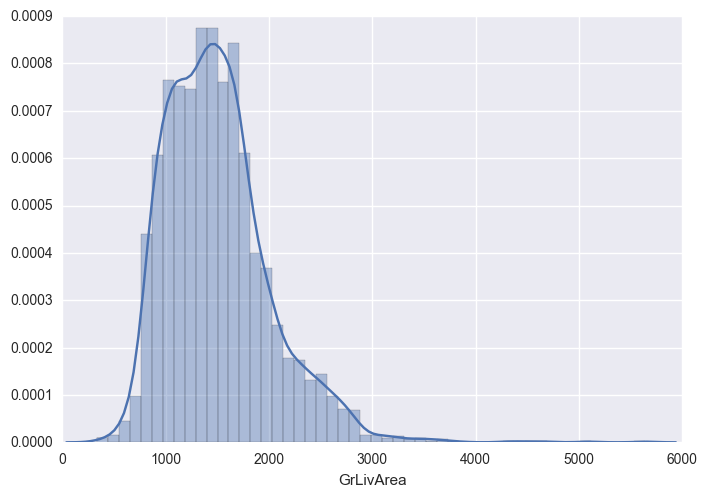

In [8]:
sns.distplot(full.GrLivArea.dropna())

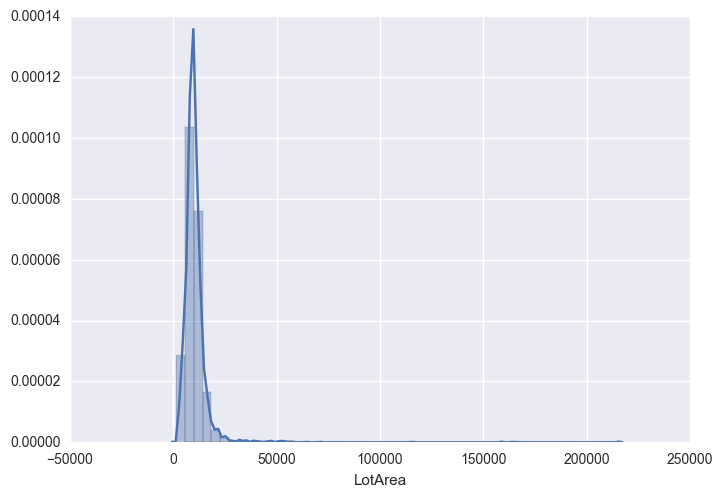

In [9]:
sns.distplot(full.LotArea.dropna())

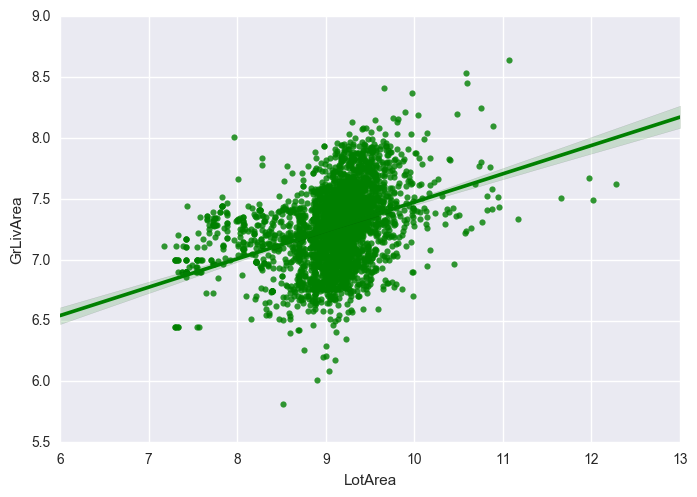

In [10]:
sns.regplot(np.log1p(full.LotArea), np.log1p(full.GrLivArea), color='g', ci=95)

### Data processing / cleansing

In [11]:
full.shape

(2919, 79)

#### Categorical combinations

In [12]:
# create lookup for numeric categorical columns
numeric_categorical = [
    'MSSubClass',
    'YearBuilt',
    'YearRemodAdd',
    'MoSold',
    'YrSold',
    'GarageYrBlt',
    'OverallQual',
    'OverallCond',
    'MiscVal',
]

# categorical column list
categorical_cols = list(full.dtypes[full.dtypes == "object"].index)
categorical_cols += numeric_categorical

# continuous column list
continuous_cols = list(full.dtypes[full.dtypes != "object"].index)
continuous_cols = [ c for c in continuous_cols if c not in numeric_categorical and c!='SalePrice' ]

#### imputing, log-transforms, encoding

In [13]:
n, m = full.shape

# store important objects
label_encoders = {}
categorical_col_nums = []

# loop through columns and delete crap columns
for col, col_data in full.iteritems():
    
    # count the nulls
    nans = np.sum(col_data.isnull())
    if nans*1.0 / n > 0.2:
        
        # drop columns that suck
        del full[col]
        if col in categorical_cols:
            categorical_cols.remove(col)

        elif col in continuous_cols:    
            continuous_cols.remove(col)
        
        if col in numeric_categorical:
            numeric_categorical.remove(col)


# second loop through columns to process data 
for col, col_data in full.iteritems():
    
    # handle categorical data
    if col_data.dtype == object or col in numeric_categorical:

        # impute missing values 
        col_data = col_data.fillna(col_data.value_counts().index[0])

        # encode categorical values
        le = LabelEncoder()
        col_data = le.fit_transform(col_data)
        categorical_col_nums.append(full.columns.get_loc(col))
        label_encoders[col] = le

        # store column 
        full.loc[:, col] = col_data

    # handle numeric data
    else:

        # check skew 
        if get_skew(full[col]):
            full.loc[:, col] = np.log1p(full[col])
            full.loc[:, col] = np.log1p(full[col])

        # handle nulls 
        nans = np.sum(col_data.isnull())
        if nans>0:
            full.loc[:, col] = full[col].fillna(np.mean(full[col].dropna()))

#### Setup standard scaler and one hot encoder

In [14]:
# standard scaler
continous_scaler = StandardScaler()
c = continous_scaler.fit_transform(full.loc[:, continuous_cols].as_matrix())

# minmax 
mm_scaler = MinMaxScaler(feature_range=(-1, 1))
m = mm_scaler.fit_transform(c)

# transform data in full dataset
full.loc[:, continuous_cols] = m 

# create one hot encoder
ohe = OneHotEncoder(categorical_features=categorical_col_nums)
o = ohe.fit_transform(full.as_matrix())

# pca for continuous columns
pca_cont_n = 1
pca_cont = PCA(n_components=pca_cont_n)
_ = pca_cont.fit(m)

# pca for ohe columns
pca_ohe_n = 1
pca_ohe = PCA(n_components=pca_ohe_n)
_ = pca_ohe.fit(o.A)

#### Processed dataset

In [15]:
# create processed dataset
train = pd.concat((full.loc[ raw.train.index, :], raw.train.SalePrice), axis=1)
test = full.loc[ raw.test.index, :] 
processed = ProcessedData( train = train ,
                           test = test )
processed.train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,3,-0.049771,-0.150812,1,3,3,0,4,0,5,2,2,0,5,6,4,110,53,1,1,12,13,1,0.729236,2,4,2,2,3,3,2,0.785715,5,-1.0,0.654186,0.801380,1,0,1,4,-0.231546,0.899983,-1.0,0.237589,0.210909,-1.000000,0.545719,0.420763,0.496609,0.210909,2,0.435695,6,-1.00000,1,94,1,0.444037,0.879093,4,4,2,-1.000000,0.610744,-1.000000,-1.0,-1.0,-1.0,0,1,2,8,4,208500
2,0,3,0.104840,-0.098820,1,3,3,0,2,0,24,1,2,0,2,5,7,83,26,1,1,8,8,2,-1.000000,3,4,1,2,3,1,0,0.822919,5,-1.0,0.746688,0.844306,1,0,1,4,0.058886,-1.000000,-1.0,0.026408,-1.000000,0.420763,0.545719,-1.000000,0.496609,0.210909,3,0.156522,6,0.09805,1,67,1,0.444037,0.856234,4,4,2,0.801593,-1.000000,-1.000000,-1.0,-1.0,-1.0,0,4,1,8,4,181500
3,5,3,-0.015700,-0.035094,1,0,3,0,4,0,5,2,2,0,5,6,4,108,52,1,1,12,13,1,0.700430,2,4,2,2,3,2,2,0.741087,5,-1.0,0.803491,0.809512,1,0,1,4,-0.176525,0.901650,-1.0,0.267197,0.210909,-1.000000,0.545719,0.420763,0.496609,0.210909,2,0.156522,6,0.09805,1,92,1,0.444037,0.892407,4,4,2,-1.000000,0.537776,-1.000000,-1.0,-1.0,-1.0,0,8,2,8,4,223500
4,6,3,-0.110878,-0.100935,1,0,3,0,0,0,6,2,2,0,5,6,4,25,20,1,1,13,15,2,-1.000000,3,4,0,3,1,3,0,0.635783,5,-1.0,0.831471,0.787191,1,2,1,4,-0.143497,0.885296,-1.0,0.240377,0.210909,-1.000000,0.098050,-1.000000,0.496609,0.210909,2,0.307695,6,0.09805,5,89,2,0.694293,0.899306,4,4,2,-1.000000,0.500297,0.825103,-1.0,-1.0,-1.0,0,1,0,8,0,140000
5,5,3,0.140377,0.058366,1,0,3,0,2,0,15,2,2,0,5,7,4,107,50,1,1,12,13,1,0.811980,2,4,2,2,3,0,2,0.776930,5,-1.0,0.819133,0.833741,1,0,1,4,-0.012596,0.924698,-1.0,0.406482,0.210909,-1.000000,0.545719,0.420763,0.650432,0.210909,2,0.546260,6,0.09805,1,91,1,0.694293,0.932096,4,4,2,0.737601,0.669594,-1.000000,-1.0,-1.0,-1.0,0,11,2,8,4,250000


#### Outliers 

outliers = [  30,   88,  197,  462,  495,  523,  557,  632,  691,  825,  874,
             898,  968,  970, 1169, 1170, 1182, 1423, 1432, 1453 ] # from outlier analysis
outlier_ids = raw.train.index.isin(outliers)
processed = ProcessedData(train=processed.train.loc[~outlier_ids ,:],
                            test=processed.test)

#### Categorical field analysis

In [16]:
categorical_field_analysis = []
for c in categorical_cols:
    # get pct freq coverage of top value 
    v = full[c].value_counts()
    first_pct = v.iloc[0]*1.0/sum(v)

    # get count of distinct values
    distinct_vals = set(full[c].values)
    d_cnt = len(distinct_vals)

    # calculate logical freq  
    logical_pct = 1.0/d_cnt
        
    # append
    categorical_field_analysis.append((c, first_pct, logical_pct, d_cnt))

categorical_field_analysis = pd.DataFrame(categorical_field_analysis,
                                 columns=['Cat_Col',
                                          'First_Freq',
                                          'Logical_Freq',
                                          'Distinct_Val_Cnt',])

In [17]:
@np.vectorize
def choose_m(freq, n):
    for i in range(1,n+1):
        if freq>=(1-float(i)/n):
            x = i
            break
    return x

In [18]:
categorical_field_analysis['m'] =\
choose_m(categorical_field_analysis.First_Freq,\
categorical_field_analysis.Distinct_Val_Cnt)

In [19]:
display(categorical_field_analysis)

,Cat_Col,First_Freq,Logical_Freq,Distinct_Val_Cnt,m
0,MSZoning,0.777321,0.200000,5,2
1,Street,0.995889,0.500000,2,1
2,LotShape,0.636862,0.250000,4,2
3,LandContour,0.898253,0.250000,4,1
4,Utilities,0.999657,0.500000,2,1
5,LotConfig,0.730730,0.200000,5,2
6,LandSlope,0.951696,0.333333,3,1
7,Neighborhood,0.151764,0.040000,25,22
8,Condition1,0.860226,0.111111,9,2
9,Condition2,0.989723,0.125000,8,1


### NN model with entity embedding

Choose reshape size for each categorical column. Push continuous columns through, as-is.

#### model topology

In [20]:
def gen_emb_nn_model(seed=2):
    np.random.seed(seed)
    models = []

    for i, vals in categorical_field_analysis.T.iteritems():

        # gather reshaping components
        m = vals.Distinct_Val_Cnt
        new_m = vals.m

        # special cases 
        if vals.Cat_Col == 'YearBuilt':
            new_m = 30
        elif vals.Cat_Col == 'GarageYrBlt':
            new_m = 25
        elif vals.Cat_Col == 'YearRemodAdd':
            new_m = 20
        elif vals.Cat_Col == 'Neighborhood':
            new_m = 10
        
        # create embedding for each feature
        entity_model = Sequential()
        entity_model.add(Embedding(m, new_m, input_length=1))
        entity_model.add(Reshape(target_shape=(new_m,)))
        models.append(entity_model)

    n,m = full[continuous_cols].shape
    m += pca_cont_n
    continuous_model = Sequential()
    continuous_model.add(Dense(m, input_dim=m))
    models.append(continuous_model)

    emb_model = Sequential()
    emb_model.add(Merge(models, mode='concat'))
    emb_model.add(Dropout(0.1))
    emb_model.add(Dense(64, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(0.2))
    emb_model.add(Dense(64, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(0.2))
    emb_model.add(Dense(32, init='uniform'))
    emb_model.add(Activation('relu'))
    emb_model.add(Dropout(0.01))
    emb_model.add(Dense(1))
    emb_model.add(Activation('sigmoid'))
    emb_model.compile(loss='mean_squared_error', optimizer='adam')
    return copy(emb_model)

#### Vanilla NN

In [21]:
# vanilla NN 
def gen_vanilla_nn(seed=2):
    np.random.seed(seed)
    n, m = preprocessing_X(X_train).shape
    vanilla_nn_model = Sequential()
    vanilla_nn_model.add(Dense(1500, init='uniform', input_shape=(m,)))
    vanilla_nn_model.add(Activation('relu'))
    vanilla_nn_model.add(Dropout(0.2))
    vanilla_nn_model.add(Dense(750, init='uniform'))
    vanilla_nn_model.add(Activation('relu'))
    vanilla_nn_model.add(Dropout(0.01))
    vanilla_nn_model.add(Dense(1))
    vanilla_nn_model.add(Activation('sigmoid'))
    vanilla_nn_model.compile(loss='mean_squared_error', optimizer='adam')
    return copy(vanilla_nn_model)

#### Preprocessing functions

In [22]:
_y = np.log1p(processed.train.SalePrice)
max_y = np.max(_y)


def nn_preprocessing_X(X_dat):
    X_out = []
    
    # categorical columns
    for c in categorical_cols:
        d = X_dat.loc[:, c].as_matrix()
        X_out.append(d)
    
    # continuous columns
    continuous_dat = X_dat.loc[:, continuous_cols].as_matrix()
    
    # pca continuous 
    pca_Xdat_cont = pca_cont.transform(continuous_dat)
    
    X_out.append(np.concatenate((continuous_dat, pca_Xdat_cont), axis=1))
    return X_out


def preprocessing_X(X_dat):
    X_dat = X_dat.copy()
    
    # continuous columns
    continuous_dat = X_dat.loc[:, continuous_cols].as_matrix()
    
    # pca continuous 
    pca_Xdat_cont = pca_cont.transform(continuous_dat)
                             
    # one hot encode 
    X_dat = ohe.transform(X_dat.as_matrix()).A
    
    # pca ohe 
    pca_Xdat_ohe = pca_ohe.transform(X_dat)
    
    return np.concatenate((X_dat, pca_Xdat_cont, pca_Xdat_ohe), axis=1)


def preprocessing_Y(y_dat):
    return np.log(y_dat.values+1)/max_y

### Modeling

In [23]:
processed.train.shape 

(1460, 75)

In [24]:
ntrain = processed.train.shape[0]
ntest = processed.test.shape[0]

In [25]:
# set up training and test data
cols = [c for c in processed.train.columns if c != 'SalePrice' ]
X_train = processed.train.loc[:, cols ]
y_train = processed.train['SalePrice']
X_test = processed.test.loc[:, cols]

#### Evaluate ridge regression coefficients

In [26]:
X_eval = pd.get_dummies(X_train, columns=categorical_cols)

In [27]:
lr = linear_model.Ridge(alpha=10.0)
_ = lr.fit(X_eval, np.log1p(y_train) / max_y)
coef_effects = np.abs(lr.coef_)
sorted_cols = np.argsort(coef_effects)[::-1]
top_cols = sorted_cols[:30]
top_200cols = sorted_cols[:200]
top_vals = coef_effects[top_cols]

In [28]:
zip( X_eval.columns[top_cols], top_vals )

[('GrLivArea', 0.018272554845475918),
 ('1stFlrSF', 0.014354723391039577),
 ('MSZoning_0', 0.011248736757394346),
 ('LotArea', 0.0096322797112857652),
 ('OverallQual_8', 0.0089242553558225076),
 ('GarageCars', 0.0078177799185871165),
 ('OverallQual_2', 0.0076699774141998096),
 ('OverallCond_2', 0.0076133454285308051),
 ('FullBath', 0.0072144771584046665),
 ('RoofMatl_0', 0.0071395932076959339),
 ('Neighborhood_15', 0.0067038002672171271),
 ('Neighborhood_22', 0.0064544329799697082),
 ('RoofMatl_7', 0.0061955726500899557),
 ('OverallQual_7', 0.0061746291302874198),
 ('OverallCond_8', 0.0061147465646835516),
 ('Neighborhood_7', 0.0057787412236506418),
 ('TotRmsAbvGrd', 0.005643304625122021),
 ('Neighborhood_16', 0.0055966814286473833),
 ('Neighborhood_6', 0.0055606921260856427),
 ('OverallQual_9', 0.0052775422151013669),
 ('OverallQual_3', 0.0051617651230118902),
 ('Functional_6', 0.0050277389191683139),
 ('Exterior1st_3', 0.0047736275839960146),
 ('TotalBsmtSF', 0.0044733697077685422),


In [29]:
def count_top200(re_str):
    return sum([ 1 if re.match(re_str, col) else 0 
        for col in X_eval.columns[top_200cols]])

In [30]:
count_top200(r'Neighborhood_[0-9]+$')

15

#### Train models

In [31]:
# Decide which models to run
switchboard = {
    'NNE': True ,
    'NNV': True ,
    'XGB': True ,
    'Other': True ,
}

# set up model arrays 
train_models = []
test_models = []

# seeds 
seeds = np.random.choice(range(100), 10, replace=False)

# loop
for s in seeds:
    ## set up K Folds ##
    NFOLDS = 4
    kf = KFold(n_splits=NFOLDS, 
               shuffle=True, 
               random_state=s)

    ## Categorical embedding NN models ##
    if switchboard['NNE']:
        emb_model = gen_emb_nn_model(seed=s)
        NN = NnWrapper(emb_model, emb=True)
        nn_oof_train, nn_oof_test = get_oof(NN)
        train_models.append(nn_oof_train)
        test_models.append(nn_oof_test)
        logging.warn('NNE score, {}: {:,.4f}'.format(s, get_rmse(nn_oof_train, y_train)))

    ## Vanilla NN models ##
    if switchboard['NNV']:
        vanilla_nn_model = gen_vanilla_nn(seed=s)
        NN2 = NnWrapper(vanilla_nn_model, emb=False)
        nn2_oof_train, nn2_oof_test = get_oof(NN2)
        train_models.append(nn2_oof_train)
        test_models.append(nn2_oof_test)
        logging.warn('NNV score, {}: {:,.4f}'.format(s, get_rmse(nn2_oof_train, y_train)))

    ## XGBoost ##
    if switchboard['XGB']:
        base_xgb_params ={
            'colsample_bytree': 0.75 ,
            'silent': 1 ,
            'subsample': 0.75 ,
            'learning_rate': 0.05 ,
            'objective': 'reg:linear' ,
            'max_depth': 4 ,
            'num_parallel_tree': 1 ,
            'min_child_weight': 1 ,
            'eval_metric': 'rmse' ,
            'nrounds': 700 ,
        }
        base_xgb_params['seed'] = 2
        XG = XgbWrapper(params=base_xgb_params)
        xgb_oof_train, xgb_oof_test = get_oof(XG)
        train_models.append(xgb_oof_train)
        test_models.append(xgb_oof_test)
        logging.warn('XGB score, {}: {:,.4f}'.format(s, get_rmse(xgb_oof_train, y_train)))

    ## other models ##
    # build models
    if switchboard['Other']:
        LS = SklearnWrapper(clf=linear_model.Lasso, params={'alpha':0.0001}, seed=s)
        RG = SklearnWrapper(clf=linear_model.Ridge, params={'alpha':10.0}, seed=s)
        RF = SklearnWrapper(clf=RandomForestRegressor, params={
                                                        'n_jobs': 4,
                                                        'n_estimators': 400,
                                                        'max_features': 0.5,
                                                        'max_depth': 12,
                                                        'min_samples_leaf': 10,
                                                    }, seed=s)
        ET = SklearnWrapper(clf=ExtraTreesRegressor, params={
                                                        'n_jobs': 4,
                                                        'n_estimators': 400,
                                                        'max_features': 0.5,
                                                        'max_depth': 12,
                                                        'min_samples_leaf': 10,
                                                    }, seed=s)
        SVRL = SklearnWrapper(clf=SVR, params={'kernel':'linear','C':0.0001,'epsilon':0.001},seed=s)
        SVRB = SklearnWrapper(clf=SVR, params={'kernel':'rbf','C':1.0,'epsilon':0.001},seed=s)
        VPW = SklearnWrapper(clf=VWRegressor, params={'l':10.0,'power_t':0.1},seed=s)

        # run models
        ls_oof_train, ls_oof_test = get_oof(LS)
        rg_oof_train, rg_oof_test = get_oof(RG)
        rf_oof_train, rf_oof_test = get_oof(RF)
        et_oof_train, et_oof_test = get_oof(ET)
        svrl_oof_train, svrl_oof_test = get_oof(SVRL)
        svrb_oof_train, svrb_oof_test = get_oof(SVRB)
        vpw_oof_train, vpw_oof_test = get_oof(VPW)

        # append models
        other_train_models = [
            ls_oof_train,
            rg_oof_train,
            rf_oof_train,
            et_oof_train,
            svrl_oof_train,
            svrb_oof_train,
            vpw_oof_train,
        ] 
        other_test_models = [
            ls_oof_test,
            rg_oof_test,
            rf_oof_test,
            et_oof_test,
            svrl_oof_test,
            svrb_oof_test,
            vpw_oof_test,
        ]
        train_models += other_train_models
        test_models += other_test_models
    
        # log scores
        lookup = ['LS','RG','RF','ET','SVRL','SVRB','VPW']
        for i, m in enumerate(other_train_models):
            logging.warn('{} score, {}: {:,.4f}'.format(lookup[i], s, get_rmse(m, y_train)))

Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exception AttributeError: "'VWRegressor' object has no attribute 'vw_'" in <bound method VWRegressor.__del__ of {}> ignored
Exceptio

#### Combine models

In [32]:
X_train = np.concatenate(train_models, axis=1)
X_test = np.concatenate(test_models, axis=1)

dtrain = xgb.DMatrix(X_train, label=preprocessing_Y(y_train))
dtest = xgb.DMatrix(X_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 1,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
}

res = xgb.cv(xgb_params, 
             dtrain, 
             num_boost_round=1000, 
             nfold=4, 
             stratified=False,
             early_stopping_rounds=25, 
             verbose_eval=200, 
             show_stdv=True)
best_nrounds = res.shape[0] - 1
xgb_final_model = xgb.train(xgb_params, dtrain, best_nrounds)

[0]	train-rmse:0.385645+0.000553303	test-rmse:0.385641+0.00167736
[200]	train-rmse:0.0536105+0.000143676	test-rmse:0.0536988+0.00124381
[400]	train-rmse:0.011438+0.000163623	test-rmse:0.012096+0.0011352
[600]	train-rmse:0.0073815+0.000172031	test-rmse:0.0085585+0.000867398
[800]	train-rmse:0.0066605+0.000155964	test-rmse:0.0081015+0.000779182


In [33]:
calc_exp = lambda x: np.exp(x*max_y)-1
print('Ensemble:\t{:,.4f}+{:,.4f}'.format(calc_exp(res.iloc[-1,0]),calc_exp(res.iloc[-1,1])))

Ensemble:	0.1141+0.0108


In [34]:
predictions = np.exp(xgb_final_model.predict(dtest)*max_y)-1

In [35]:
submission = pd.DataFrame(np.vstack((raw.test.index.astype(str).ravel(), 
                                     predictions.ravel())).T,
                          columns=['Id','SalePrice'])
submission.to_csv('submission.csv', index=False)